Restructuring inspired by [photometry_from_aec_emulator.ipynb](photometry_from_aec_emulator.ipynb) and some discussion w/ Michelle.

In [1]:
import time
import functools
import multiprocessing
from pathlib import Path
from copy import deepcopy

import numpy as np

from astropy import units as u
from astropy.io import fits
from astropy.modeling import models, fitting

from astroquery.svo_fps import SvoFps


from specutils import Spectrum1D, manipulation

from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from tqdm.auto import tqdm

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
tensor_dtype = torch.float32
if device == 'cpu':
    tensor_dtype = torch.float64
print(f"Using {device} device with dtype {tensor_dtype}")

Using cuda device with dtype torch.float32


In [3]:
datapath = Path('../fullgrid/')

# Load Data

Mostly taken from [resampling_tensors.ipynb](resampling_tensors.ipynb)

In [4]:
wlspath = datapath / 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'

wlsraw = fits.getdata(wlspath)
model_wls = wlsraw << u.Unit(fits.getheader(wlspath)['UNIT'])

model_wls, len(model_wls)

(<Quantity [  500.  ,   500.1 ,   500.2 , ..., 54999.25, 54999.5 , 54999.75] Angstrom>,
 1569128)

In [5]:
allspecpaths = list(datapath.glob('lte*HiRes.fits'))
len(allspecpaths)

7559

But some of them have no BUINT, it turns out those are wrong in an unclear way so we skip them.

In [6]:
goodspecpaths = [p for p in allspecpaths if 'BUNIT' in fits.getheader(p)]
len(goodspecpaths)

7508

In [7]:
specunit = u.Unit(fits.getval(goodspecpaths[0], 'BUNIT'))

# Pick bands and wavelength range

This sets up a wavelength range for interpolation that spans a specific set of photometic bands at a wavelength spacing that is not-crazy for the filter responses available.

In [8]:
filters = ['HST/WFC3_UVIS1.F275W', 'HST/WFC3_UVIS1.F336W', 
           'HST/ACS_WFC.F475W', 'HST/ACS_WFC.F814W', 
           'HST/WFC3_IR.F110W', 'HST/WFC3_IR.F160W']

transmission = {filtname.split('.')[-1]:SvoFps.get_transmission_data(filtname) for filtname in filters}

In [9]:
wls = [u.Quantity(ttab['Wavelength'], u.angstrom) for ttab in transmission.values()]

dwls = []
for wl in wls:
    dwls.append(np.diff(wl))
dwls = np.concatenate(dwls)

qs = np.quantile(dwls, [.01, .05, .1, .5, .9])
qs

<Quantity [4.880000e-04, 4.995120e-01, 5.000000e-01, 5.000000e-01,
           3.592285e+00] Angstrom>

In [10]:
dwl = qs[2]
dwl

<Quantity 0.5 Angstrom>

In [11]:
minwl = np.concatenate(wls).min()
maxwl = np.concatenate(wls).max()
minwl, maxwl

(<Quantity 2161. Angstrom>, <Quantity 17204.697266 Angstrom>)

In [12]:
minwl

<Quantity 2161. Angstrom>

In [13]:
(minwl.to(u.angstrom), maxwl.to(u.angstrom), dwl.to(u.angstrom))

(<Quantity 2161. Angstrom>,
 <Quantity 17204.697266 Angstrom>,
 <Quantity 0.5 Angstrom>)

In [14]:
(maxwl-minwl)//dwl  + 1

<Quantity 30088.>

In [15]:
fine_wl = np.linspace(minwl.to(u.angstrom)*.99, maxwl.to(u.angstrom)*1.01, int((maxwl*1.01-minwl*.99)//dwl  + 1))
len(fine_wl)

30475

that's way too fine to realistically train.  Lets try shrinking it down for now and see if it works ok anyway.

In [16]:
data_wls = fine_wl[::10]
len(data_wls)

3048

# Do the interpolation to more reasonable-size spectra

In [17]:
resampler = manipulation.FluxConservingResampler()

def interpolate_and_return_flux(specpath, data_wls=data_wls, resampler=resampler):
    header = dict(fits.getheader(specpath, ext=0))
    spec = Spectrum1D(spectral_axis=model_wls, flux=fits.getdata(specpath, ext=0) << u.Unit(header['BUNIT']))
    newspec = resampler(spec, data_wls)

    return newspec.flux.value

In [18]:
tointerpolate = [p for p in allspecpaths if 'BUNIT' in fits.getheader(p)]
len(tointerpolate), len(allspecpaths)

with multiprocessing.Pool(16) as pool:
      results = list(tqdm(pool.imap(interpolate_and_return_flux, tointerpolate), total=len(tointerpolate)))
len(results)

  0%|          | 0/7508 [00:00<?, ?it/s]

7508

In [19]:
fluxes = torch.from_numpy(np.array(results))
fluxes.shape

torch.Size([7508, 3048])

In [20]:
teff = torch.tensor([fits.getval(p, 'PHXTEFF') for p in tointerpolate])
logg = torch.tensor([fits.getval(p, 'PHXLOGG') for p in tointerpolate])
feh = torch.tensor([fits.getval(p, 'PHXM_H') for p in tointerpolate])

infeatures = torch.stack([teff,logg,feh], dim=1)
infeature_names = 'Teff,logg,FeH'.split(',')

# Timing and accuracy tests for black body flux scaling

Text(0, 0.5, 'time [ms]')

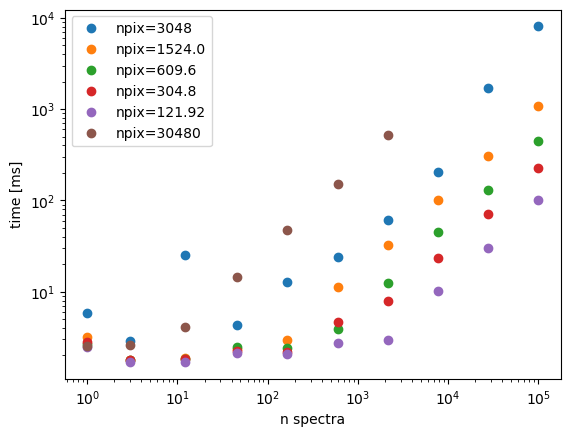

In [21]:
def ttest(n, wls):
    t = np.random.rand(n)*10000 + 2000
    
    st = time.time()
    bb = models.BlackBody(temperature=t*u.K, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    flux = bb(wls[..., None])*(np.pi*u.sr)
    mf = np.mean(flux, axis=0)
    mfv = torch.from_numpy(mf.value) # not always necessary but just in case
    et = time.time()
    
    return mf, 1000*(et-st) # time in millisec

ns = np.logspace(0, 5, 10).astype(int)
times = [ttest(ni, data_wls)[1] for ni in ns]
times2 = [ttest(ni, data_wls[::2])[1] for ni in ns]
times5 = [ttest(ni, data_wls[::5])[1] for ni in ns]
times10 = [ttest(ni, data_wls[::10])[1] for ni in ns]
times25 = [ttest(ni, data_wls[::25])[1] for ni in ns]
wlx10 = np.linspace(data_wls[0], data_wls[-1], len(data_wls)*10)
timesx10 = [ttest(ni, wlx10)[1] for ni in ns[:-3]]
plt.loglog(ns, times, 'o', label=f'npix={len(data_wls)}')
plt.loglog(ns, times2, 'o', label=f'npix={len(data_wls)/2}')
plt.loglog(ns, times5, 'o', label=f'npix={len(data_wls)/5}')
plt.loglog(ns, times10, 'o', label=f'npix={len(data_wls)/10}')
plt.loglog(ns, times25, 'o', label=f'npix={len(data_wls)/25}')
plt.loglog(ns[:-3], timesx10, 'o', label=f'npix={len(data_wls)*10}')
plt.legend(loc=0)
plt.xlabel('n spectra')
plt.ylabel('time [ms]')

There's a floor of ~ a few msecs, which might be a bit on the slow side. Seems like it scales for reasonable batch sizes until we get to thousands of pixels.  Is that good enough?

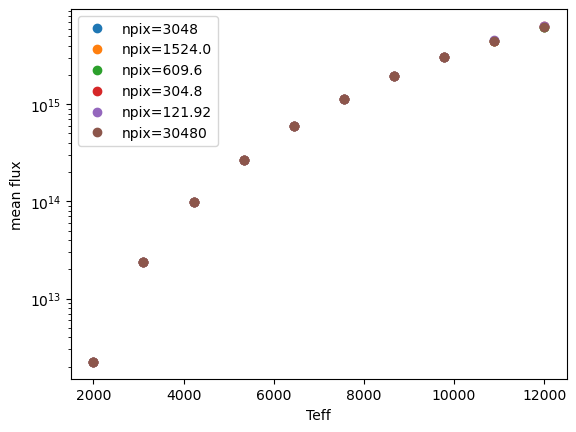

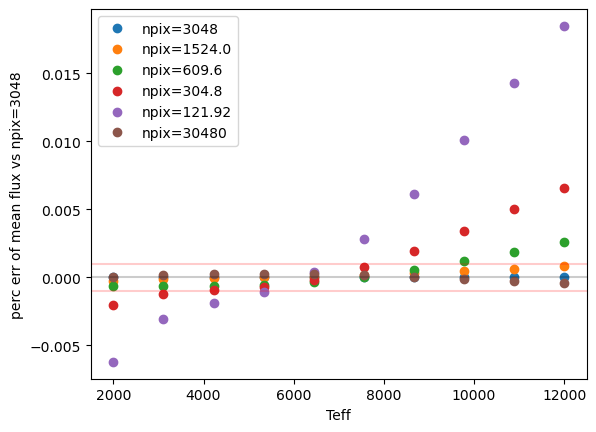

In [22]:
def mtest(nteffs, wls):
    t = np.linspace(2000,12000,nteffs)*u.K
    
    bb = models.BlackBody(temperature=t, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
    flux = bb(wls[..., None])*(np.pi*u.sr)
    mf = np.mean(flux, axis=0)
    mfv = torch.from_numpy(mf.value) # not always necessary but just in case
    
    return t, mf

n = 10
teffs, means = mtest(n, data_wls)
means2 = mtest(n, data_wls[::2])[1]
means5 = mtest(n, data_wls[::5])[1]
means10 = mtest(n, data_wls[::10])[1]
means25 = mtest(n, data_wls[::25])[1]
wlx10 = np.linspace(data_wls[0], data_wls[-1], len(data_wls)*10)
meansx10 = mtest(n, wlx10)[1]

plt.semilogy(teffs, means, 'o', label=f'npix={len(data_wls)}')
plt.semilogy(teffs, means2, 'o', label=f'npix={len(data_wls)/2}')
plt.semilogy(teffs, means5, 'o', label=f'npix={len(data_wls)/5}')
plt.semilogy(teffs, means10, 'o', label=f'npix={len(data_wls)/10}')
plt.semilogy(teffs, means25, 'o', label=f'npix={len(data_wls)/25}')
plt.semilogy(teffs, meansx10, 'o', label=f'npix={len(data_wls)*10}')
plt.legend(loc=0)
plt.xlabel('Teff')
plt.ylabel('mean flux')

plt.figure()

plt.plot(teffs, means / means - 1, 'o', label=f'npix={len(data_wls)}')
plt.plot(teffs, means2 / means - 1, 'o', label=f'npix={len(data_wls)/2}')
plt.plot(teffs, means5 / means - 1, 'o', label=f'npix={len(data_wls)/5}')
plt.plot(teffs, means10 / means - 1, 'o', label=f'npix={len(data_wls)/10}')
plt.plot(teffs, means25 / means - 1, 'o', label=f'npix={len(data_wls)/25}')
plt.plot(teffs, meansx10 / means - 1, 'o', label=f'npix={len(data_wls)*10}')
plt.axhline(0, c='k', alpha=.2)
plt.axhline(0.001, c='r', alpha=.2)
plt.axhline(-0.001, c='r', alpha=.2)
plt.legend(loc=0)
plt.xlabel('Teff')
plt.ylabel(f'perc err of mean flux vs npix={len(data_wls)}');

Hmm, so there is a few ppt error at < 1000 pixels.  What about a grid interpolation? Lets try using the actually teffs present:

In [23]:
uteffs = np.unique(teff)*u.K
uteffs.shape, uteffs

((73,),
 <Quantity [ 2300.,  2400.,  2500.,  2600.,  2700.,  2800.,  2900.,  3000.,
             3100.,  3200.,  3300.,  3400.,  3500.,  3600.,  3700.,  3800.,
             3900.,  4000.,  4100.,  4200.,  4300.,  4400.,  4500.,  4600.,
             4700.,  4800.,  4900.,  5000.,  5100.,  5200.,  5300.,  5400.,
             5500.,  5600.,  5700.,  5800.,  5900.,  6000.,  6100.,  6200.,
             6300.,  6400.,  6500.,  6600.,  6700.,  6800.,  6900.,  7000.,
             7200.,  7400.,  7600.,  7800.,  8000.,  8200.,  8400.,  8600.,
             8800.,  9000.,  9200.,  9400.,  9600.,  9800., 10000., 10200.,
            10400., 10600., 10800., 11000., 11200., 11400., 11600., 11800.,
            12000.] K>)

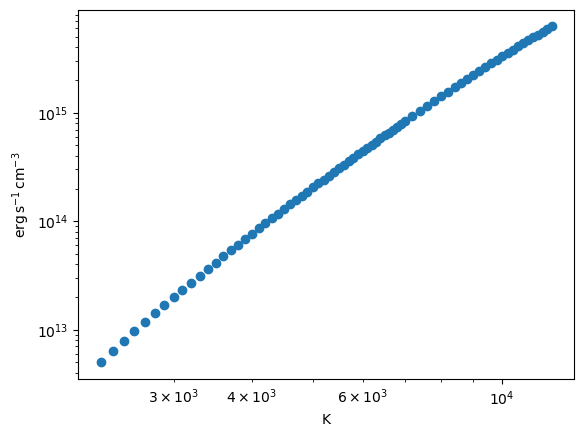

In [24]:
bb = models.BlackBody(temperature=uteffs, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
flux = bb(wlx10[..., None])*(np.pi*u.sr)
mf = np.mean(flux, axis=0)
plt.loglog(uteffs, mf, 'o')

Close to a power law.  Good enough?

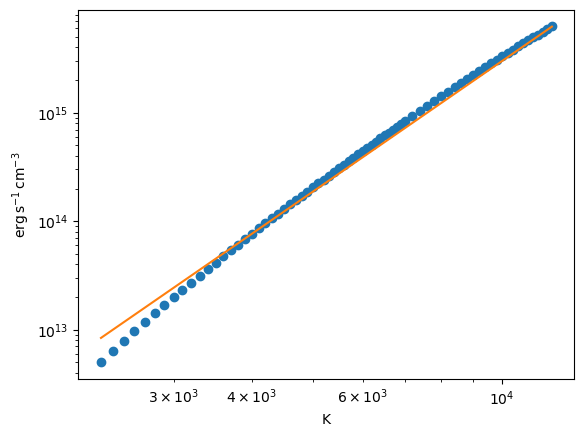

In [25]:
pl = models.PowerLaw1D(.3, 1*u.K, -4)

plt.loglog(uteffs, mf, 'o')
plt.plot(uteffs, pl(uteffs).value)

Not good enough.  Polynomial in log-space?

(0.2346038818359375, 73, <Quantity 5.31086874e-09>, <Quantity 0.00010491>)

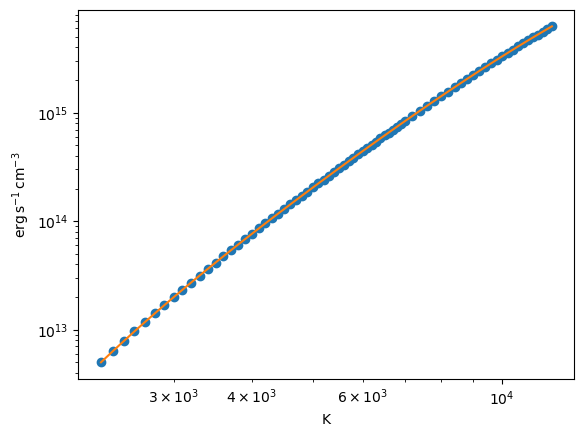

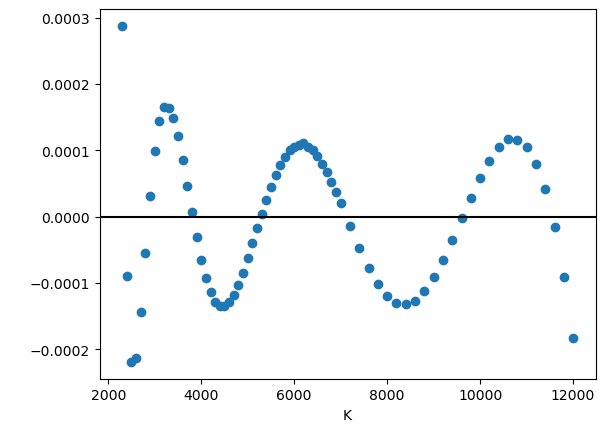

In [26]:
teffpoly = fitting.LinearLSQFitter()(models.Polynomial1D(6), np.log10(uteffs/u.K), np.log10(mf.value))

plt.loglog(uteffs, mf, 'o')
plt.plot(uteffs, 10**teffpoly(np.log10(uteffs/u.K)).value)

plt.figure()
percerror = 10**teffpoly(np.log10(uteffs/u.K))/mf.value - 1
plt.plot(uteffs, percerror, 'o')
plt.axhline(0,c='k')


st = time.time() 
teffpoly(np.log10(uteffs/u.K))
et = time.time()
(et-st)*1000, len(uteffs), np.mean(percerror), np.std(percerror)

# Create the Model

The model here is a few layered components:
* MLP from the input feature space to some fixed size restricted "latent-like" space.
* A resnet-style expansion from the latent space to the pixel space

In [143]:
class SpectrumEmulator(nn.Module):
    def __init__(self, feature_mlp_nneurons, resnet_nneurons, teffindex=0, 
                       logifyteff=False, data_wls=data_wls, activation_cls=nn.GELU):
        """
        output pixels implicitly set by data_wls, input by first of feature_mlp_nneurons
        """
        super().__init__()

        self.data_wls = data_wls.to(u.angstrom)
        self.teffindex = teffindex
        self.logifyteff = logifyteff
        
        noutpixels = len(data_wls)

        mlp_layers = []
        for ni, no in zip(feature_mlp_nneurons[:-1], feature_mlp_nneurons[1:]):
            mlp_layers.append(nn.Linear(ni, no))
            mlp_layers.append(activation_cls())


        self.mlp = nn.Sequential(*mlp_layers)

        assert feature_mlp_nneurons[-1] == resnet_nneurons[0], 'the mlp must end with the same number of neurons as the resnet starts with!' 
        assert resnet_nneurons[0] == resnet_nneurons[-1], 'the resnet must start and end at the same number of neurons'

        res_layers = []
        for ni, no in zip(resnet_nneurons[:-1], resnet_nneurons[1:]):
            res_layers.append(nn.Linear(ni, no))
            res_layers.append(activation_cls())
        
        self.resishnet = nn.Sequential(*res_layers)

        self.outputnet = nn.Sequential(nn.Linear(resnet_nneurons[-1], noutpixels),
                                       activation_cls(),
                                       nn.Linear(noutpixels, noutpixels),
                                      )

        self.loss_fcn = nn.MSELoss()
        self.optimizer_cls = torch.optim.AdamW
        self.scheduler_cls = None

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype

    def bbscale(self, flux, teff):
        bbmean = self.bbmean(teff)
        y = flux/bbmean - 1
        return y

    def bbunscale(self, y, teff):
        bbmean = self.bbmean(teff)
        flux = (y + 1) * bbmean
        return flux

    def bbmean(self, teff):
        # fast approximation from above
        if isinstance(teff, u.Quantity):
            teff = teff/u.K
        if isinstance(teff, torch.Tensor):
            teff = teff.to('cpu')
        res = 10**teffpoly(np.log10(teff))
        return self.convert_input(torch.from_numpy(res.value))
        
    def bbmean_direct(self, teff):
        """
        teff should be scalar or 1d
        """
        # TODO: implement caching if needed
        bb = models.BlackBody(temperature=teff, scale=1*u.erg/u.s * u.cm**-3 / u.sr)
        flux = bb(self.data_wls[..., None])*(np.pi*u.s)
        return flux.mean(axis=0)

    def convert_input(self, t):
        t = torch.atleast_2d(t)
        return t.to(self.device, dtype=self.dtype)

    def forward(self, x, in_convert=True):
        """
        the output is not descaled here, use `forward_descale` if that's what's desired
        """
        if in_convert:
            x = self.convert_input(x)
        
        if self.logifyteff:
            x = x.copy()
            x[..., self.teffindex] = torch.log10(x[..., self.teffindex])
    
        ym = self.mlp(x)
        yr = self.resishnet(ym)
        return self.outputnet(yr + ym)
            
    def forward_descale(self, x, in_convert=True):
        if in_convert:
            x = self.convert_input(x)
        return self.bbunscale(self.forward(x), x[..., self.teffindex])

    def train_and_validate(self, infeatures, fluxes, nepochs, batch_size,
                                 tetrsplit=[.3, .7], split_seed=42, optkwargs={}, shuffle_batches=True):
        inteff = infeatures[..., self.teffindex][..., None]
        scaled_fluxes = self.bbscale(self.convert_input(fluxes), inteff)
        dataset = TensorDataset(self.convert_input(infeatures), scaled_fluxes)
        
        split_data = random_split(dataset, tetrsplit, torch.Generator().manual_seed(split_seed))
        valid_data, train_data = split_data

        optimizer = self.optimizer_cls(self.parameters(), **optkwargs)
        if self.scheduler_cls is not None:
            scheduler = self.scheduler_cls(optimizer)
            
        niters = 0
        valid_losses = []
        valid_niters = []    
        train_losses = []
        train_niters = []
        lrs = []

        valid_x = valid_data.dataset.tensors[0][valid_data.indices]
        valid_y = valid_data.dataset.tensors[1][valid_data.indices]
        def validation_fcn():
            self.eval()
            with torch.no_grad():
                pred = self(valid_x, in_convert=False)
                valid_loss = self.loss_fcn(pred, valid_y).item()
                valid_losses.append(valid_loss)
                valid_niters.append(niters)
            return valid_loss

        for _ in (pbar := tqdm(range(nepochs))):
            self.train()

            for data in DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_batches):
                X, Y = data[:2]
                optimizer.zero_grad()
                
                pred = self(X, in_convert=False)
                loss = self.loss_fcn(pred, Y)
                
                loss.backward()
                optimizer.step()
        
                niters += X.shape[0]
                
                train_losses.append(loss.item())
                train_niters.append(niters)

            if self.scheduler_cls is not None:
                scheduler.step()
                lrs.append(scheduler.get_last_lr())
            valid_loss = validation_fcn()
            if self.scheduler_cls  is None:
                pbar.set_description(f'valid loss={valid_loss:.3e}')
            else:
                pbar.set_description(f'valid loss={valid_loss:.3e}, lr={lrs[-1][0]:.3e}')

        return (valid_niters, valid_losses), (train_niters, train_losses), lrs, split_data
        

In [ ]:
def plot_sample_specs(model, dataset_to_plot, idxs=5, descale=False, wlrng=(14000*u.angstrom, 15000*u.angstrom)):
    if isinstance(idxs, int):
        idxs = np.random.randint(len(dataset_to_plot), size=5)

    wl = model.data_wls

    figs = []
    for idx in idxs:
        true_idx = dataset_to_plot.indices[idx]
        Xi, Yi = [xy[true_idx] for xy in dataset_to_plot.dataset.tensors]
        
        pred = model(Xi[None,...])[0].detach()
        if descale:
            teffs = model.convert_input(Xi[..., model.teffindex][..., None])
            pred = model.bbunscale(pred, teffs)[0]
            Yi = model.bbunscale(Yi, teffs)[0]
            
        fig, axs = plt.subplots(1, 3, figsize=(12, 6))
        figs.append(fig)
        ax1, ax2, ax3 = axs
        
        ax1.plot(wl, Yi.cpu(), lw=1, label='true')
        ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
        ax1.legend(loc=0)
        ax1.set_title(f'{idx}')
        
        msk = (wlrng[0]<model.data_wls)&(model.data_wls<wlrng[1])
        ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
        ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
        ax2.legend(loc=0)
        ax2.set_title(f'{true_idx} - zoom')
        
        ax3.plot(wl, (Yi.cpu()-pred.cpu())/Yi.cpu(), lw=1, label='true')
        ax3.set_title(f'{true_idx} - frac residual')
        
    return figs

/tmp/ipykernel_4970/2908606388.py:66: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  res = 10**teffpoly(np.log10(teff))


  0%|          | 0/100 [00:00<?, ?it/s]

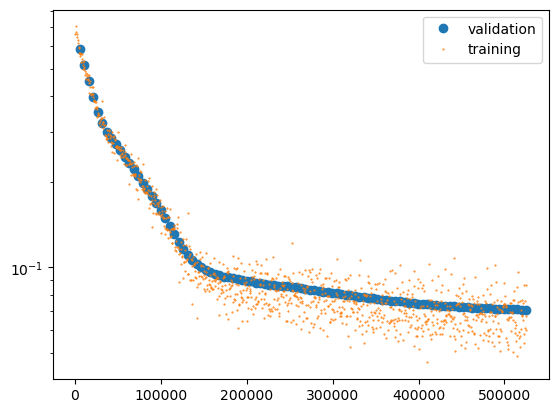

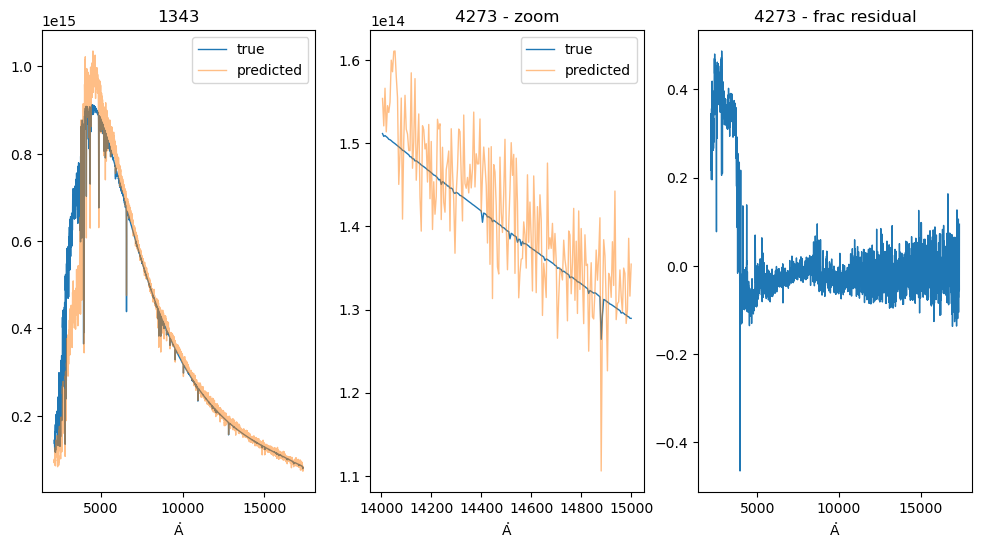

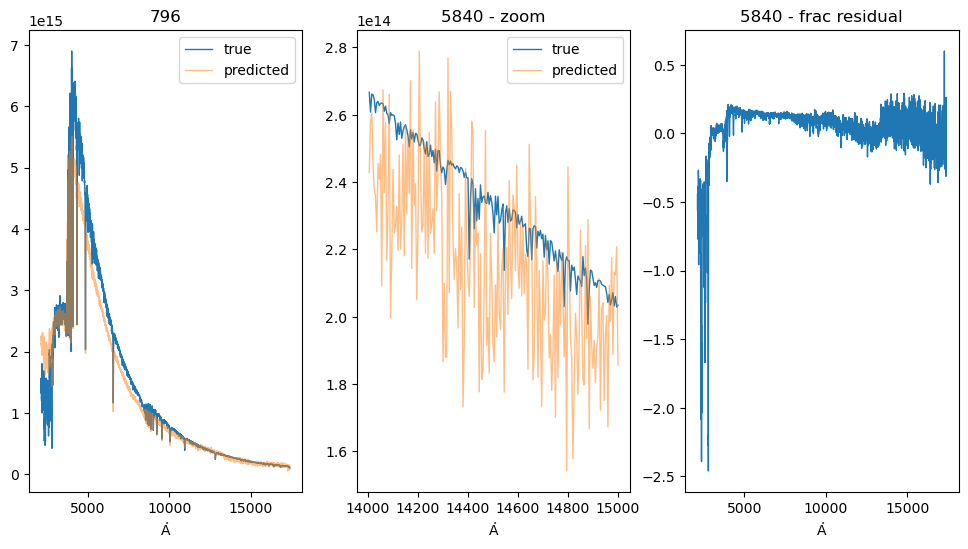

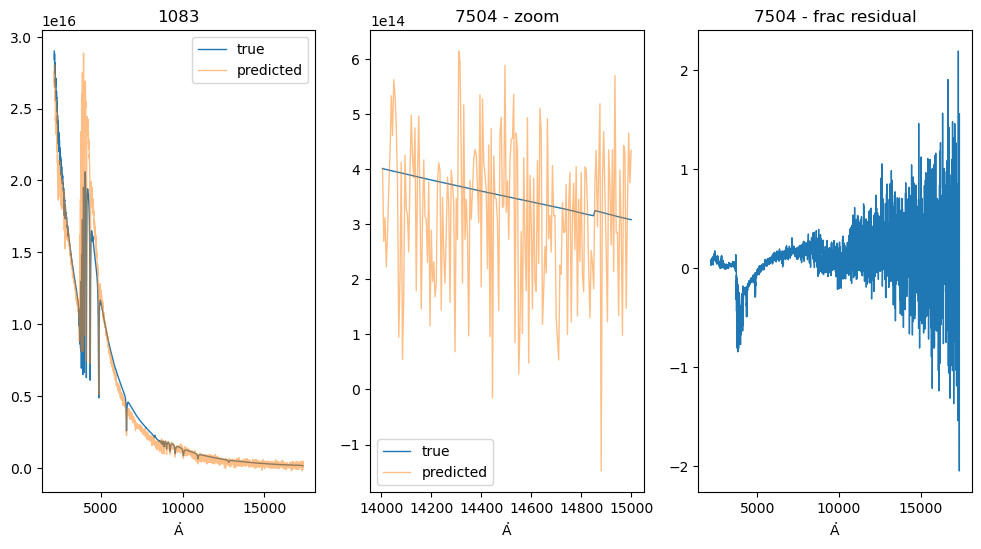

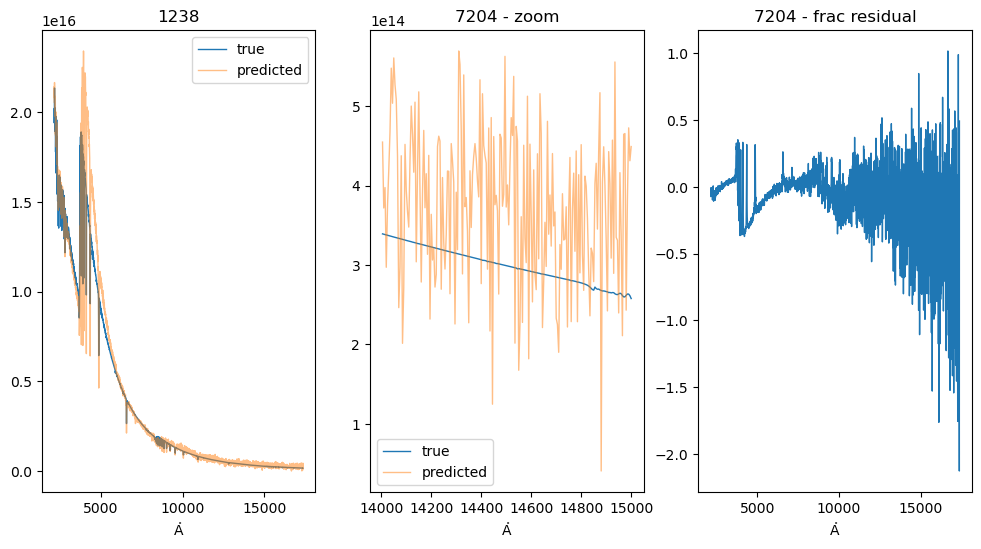

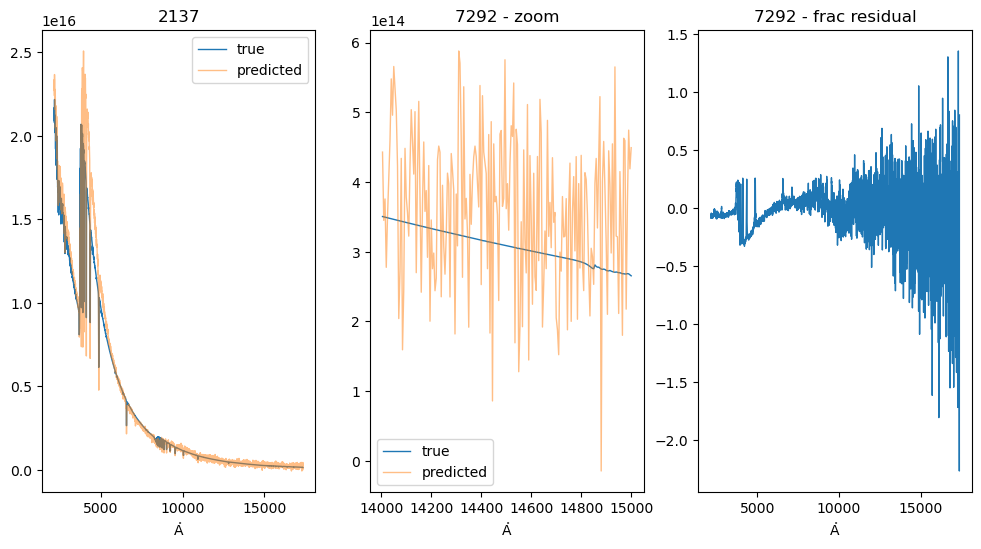

In [159]:
model = SpectrumEmulator(feature_mlp_nneurons=[3, 8,   16,   32,   64,  128, 256, 128, 64, 256, 512], 
                         resnet_nneurons=[ 512, 1024, 1024, 512])
model = model.to(device, dtype=tensor_dtype)

valid, train, lrs, data_split =  model.train_and_validate(infeatures, fluxes, 100, 512,
                                                         optkwargs=dict(lr=1e-5,
                                                                        weight_decay=1e-5))

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
if lrs:
    plt.twinx()
    plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
    plt.ylabel('learning rate', color='C2')

plot_sample_specs(model, data_split[0], descale=True);